In [4]:
from TensorHelpers import *
from QFT import *
from MPS import *

import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import array_to_latex

# Benchmark functionality

In [5]:
def run_benchmark(N, f, fft_start=0.0, fft_end=1.0, max_bond_mps=10, max_bond_mpo=8, cutoff_mps=1e-12, cutoff_mpo=1e-12, verbose=False):
    mps = MPS(N)
    qft = QFT(N)
   
    # Computing benchmark for MPS and MPO
    mps_start = timeit.default_timer() 
    mps = mps.create_MPS([f], fft_start, fft_end, max_bond=max_bond_mps, cutoff=cutoff_mps, reverse=True)
    mps_construct_time = timeit.default_timer() - mps_start
   
    qft_start = timeit.default_timer() 
    qft = qft.create_MPO(max_bond_dim=max_bond_mpo, cutoff=cutoff_mpo, reverse=True)
    qft_construct_time = timeit.default_timer() - qft_start
    
    qft_apply_start = timeit.default_timer() 
    qft_res = qft.apply(mps)
    qft_apply_time = timeit.default_timer() - qft_apply_start
   
    # Total time 
    mps_construct_apply_time = mps_construct_time + qft_apply_time
    
    if verbose:
        print(f"====== Results for benchmark (N={N}, max_bond={max_bond_mps}, cutoff={cutoff_mps}) ======")
        print("MPS Construct Time: ", mps_construct_time)
        print("QFT Construct Time: ", qft_construct_time)
        print("QFT Apply Time: ", qft_apply_time)
        print("MPS + Apply Time: ", mps_construct_apply_time, "\n")
   
        # Comparing accuracy to FFT
        input = np.arange(fft_start, fft_end, step=1/(2**N))
        output = f(input)
        fft_out_vec = np.fft.fft(output).reshape(-1,) / 2**(N/2)
        qft_out_vec = qft_res.to_dense().reshape(-1,)

        print("QFT vs FFT Error: ", np.linalg.norm(fft_out_vec - qft_out_vec))

    return qft_apply_time, mps_construct_apply_time

def run_benchmark_fft(N, f, fft_start=0.0, fft_end=1.0):
    input = np.arange(fft_start, fft_end, step=1/(2**N))
    output = f(input)
    fft_start = timeit.default_timer()
    fft_out_vec = np.fft.fft(output).reshape(-1,) / 2**(N/2)
    fft_time = timeit.default_timer() - fft_start
    return fft_time
    

# Testing Benchmark

In [13]:
run_benchmark(16, lambda x: np.cos(x), verbose=True, max_bond_mps=6, max_bond_mpo=6, cutoff_mps=1e-12, cutoff_mpo=1e-12)

====== Results for benchmark (N=16, max_bond=6, cutoff=1e-12) ======
MPS Construct Time:  0.009470198998315027
QFT Construct Time:  0.49391406100039603
QFT Apply Time:  0.004518500998528907
MPS + Apply Time:  0.013988699996843934 

QFT vs FFT Error:  0.03690362135397189


(0.004518500998528907, 0.013988699996843934)

In [2]:
run_benchmark(16, lambda x: np.cos(x))

NameError: name 'MPS' is not defined

In [5]:
run_benchmark(20, lambda x: np.cos(x), max_bond=-1, cutoff=1e-15)

====== Results for benchmark (N=20, max_bond=-1, cutoff=1e-15) ======
MPS Construct Time:  0.19002685899977223
QFT Construct Time:  2.3637312239989114
QFT Apply Time:  0.014907057000527857
Total Time:  2.5686651399992115 

QFT vs FFT Error:  1.330717896952343e-09


In [6]:
run_benchmark(26, lambda x: np.cos(x), max_bond=-1, cutoff=1e-15)

====== Results for benchmark (N=26, max_bond=-1, cutoff=1e-15) ======
MPS Construct Time:  5.5631886680002935
QFT Construct Time:  3.7497952909998276
QFT Apply Time:  0.019454530998700648
Total Time:  9.332438489998822 

QFT vs FFT Error:  0.00017825112670845865


# Plotting Benchmark

In [3]:
function_names = ["Gaus", "Cos", "Cusps", "FFT"]
functions = [lambda x: np.exp(-(x - 0.5)**2 / 0.1**2), lambda x: np.cos(2*np.pi*x), lambda x: np.cos(2*np.pi*x) + 2*np.exp(-3*np.abs(x - 0.2)), lambda x: np.cos(2*np.pi*x)]

start_qubits = 4
end_qubits = 26

for i in range(len(functions)):
    # data storage
    runtimes = []
    mpo_mps_apply_runtimes = []

    f = functions[i]
    f_name = function_names[i]

    qubit_range = np.arange(start_qubits, end_qubits)
    for N in qubit_range:
      if f_name == "FFT":
        fft_runtime = run_benchmark_fft(N,f)
        runtimes.append(fft_runtime)
        mpo_mps_apply_runtimes.append(0)
      else:
        mpo_runtime, mpo_mps_apply_runtime = run_benchmark(N, f)
        runtimes.append(mpo_runtime)
        mpo_mps_apply_runtimes.append(mpo_mps_apply_runtime)
        
    print(f"Function {f_name} complete!")

    pd.DataFrame({'N': qubit_range, 'Runtime': runtimes, 'MPO + MPS Apply Runtime': mpo_mps_apply_runtimes}).to_csv(f'{f_name}_Benchmark.csv', index=False)



## Plotting saved CSVs

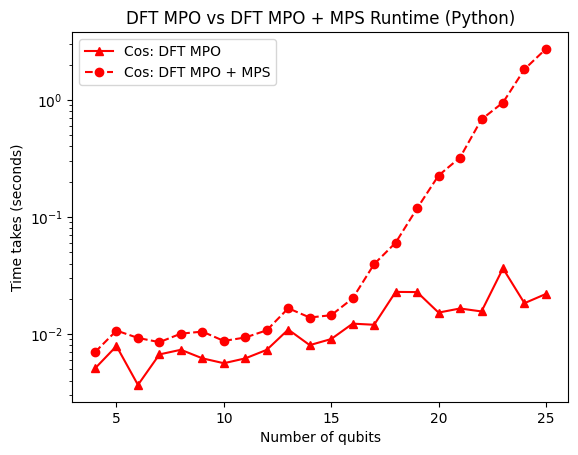

In [25]:
def plot_mpo_func(func_name, color):
    df = pd.read_csv(f'{func_name}_Benchmark.csv')

    if func_name == "FFT":
      plt.plot(df['N'], df['Runtime'], linestyle='-', marker='*', color=color, label=f"{func_name}")
    else:
      plt.plot(df['N'], df['Runtime'], linestyle='-', marker='^', color=color, label=f"{func_name}: DFT MPO")
      plt.plot(df['N'], df['MPO + MPS Apply Runtime'], linestyle='--', marker='o', color=color, label=f"{func_name}: DFT MPO + MPS")

  

colors = ['b', 'r', 'g', 'k']
for color, func_name in zip(colors, function_names):
    plot_mpo_func(func_name, color)

plt.title("DFT MPO vs DFT MPO + MPS Runtime (Python)")
plt.xlabel("Number of qubits")
plt.ylabel("Time takes (seconds)")
plt.yscale('log')
plt.legend()
plt.savefig('graph_python.png')